### News Impact

In [453]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [454]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://localhost',
                       connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [455]:
import pandas as pd

tck_qry = pd.read_sql_query('''select symbol, avg(volume*close) from USE_2021
    group by symbol order by avg(volume*close) desc limit 5''',
                            conn)
tdf = pd.DataFrame(tck_qry, columns=['symbol'])
tickers = tdf['symbol']

In [456]:
def query_symbol(sym, conn):
    qry = pd.read_sql_query(
        '''select tradedate, pct_close from USEQ_HIST
        where symbol="''' + sym + '''"
        and volume>0
         order by tradedate''',
        conn,
        index_col='tradedate'
    )
    return sym, pd.DataFrame(qry, columns=["pct_close"])

In [457]:
import math
def ann_var(var):
    return (math.sqrt((var)*252))

def H_Garch(x, alpha, beta, omega):
    A = omega + beta*(omega/(1-alpha-beta))
    return A + alpha*(x**2)

In [458]:
def H_GJR(x, alpha, gamma, omega, beta):
    A = omega + beta*(omega/(1-alpha-(gamma/2)-beta))
    if x >=0.0:
        return A + alpha*(x**2)
    else:
        return A + (alpha+gamma)*(x**2)

In [459]:
from arch import arch_model
x = np.linspace(-5,5,21)
ticker, df = query_symbol('MS', conn)
am = arch_model(df['pct_close'])
res = am.fit(disp='off')
forecasts = res.forecast(reindex=False)
Omega, Alpha, Beta = [res.params['omega'], res.params['alpha[1]'], res.params['beta[1]']]
Mean = forecasts.mean['h.1'].iloc[0]
Var = forecasts.variance['h.1'].iloc[0]
H = math.sqrt(Var*252)

In [460]:
yg = []
for xi in x:
    yy = H_Garch(xi, Alpha, Omega, Beta)
    yg.append(yy + H)


In [461]:
am = arch_model(df['pct_close'], p=1, o=1, q=1)
res = am.fit(disp='off')
forecasts = res.forecast(reindex=False)
Omega, Alpha, Gamma, Beta = [res.params['omega'], res.params['alpha[1]'], res.params['gamma[1]'], res.params['beta[1]']]
Mean = forecasts.mean['h.1'].iloc[0]
Var = forecasts.variance['h.1'].iloc[0]

In [462]:
y = []
for xi in x:
    yy = H_GJR(xi, Alpha, Gamma, Omega, Beta)
    y.append(yy + H)

In [463]:
am = arch_model(df['pct_close'], p=1, o=1, q=1, dist='StudentsT')
res = am.fit(disp='off')
forecasts = res.forecast(reindex=False)
Omega, Alpha, Gamma, Beta = [res.params['omega'], res.params['alpha[1]'], res.params['gamma[1]'], res.params['beta[1]']]
Mean = forecasts.mean['h.1'].iloc[0]
Var = forecasts.variance['h.1'].iloc[0]
H = math.sqrt(Var*252)

In [464]:
yt = []
for xi in x:
    ytt = H_GJR(xi, Alpha, Gamma, Omega, Beta)
    yt.append(ytt + H)

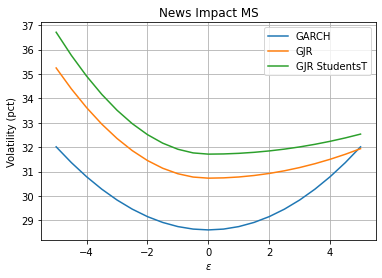

In [465]:
plt.plot(x,yg, label='GARCH')
plt.plot(x,y, label='GJR')
plt.plot(x,yt, label='GJR StudentsT')
plt.xlabel(r'$\epsilon$')
plt.ylabel('Volatility (pct)')
plt.title('News Impact MS')
plt.legend(loc='best')
plt.grid('both')


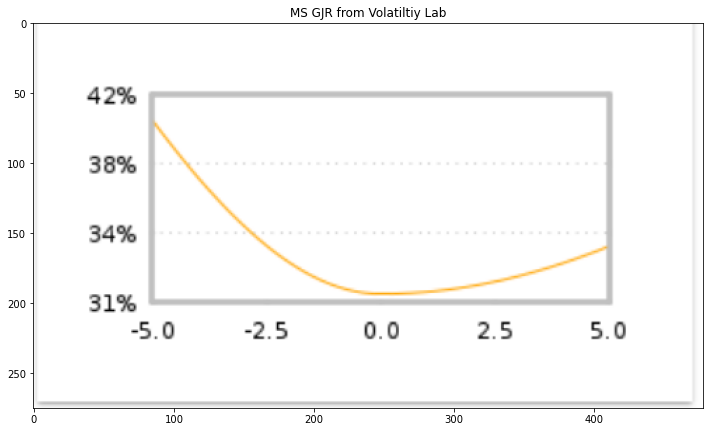

In [466]:
# see https://youtrack.jetbrains.com/issue/PY-29177
import matplotlib.pyplot as plt
plt.figure(figsize=(12,18))
img = plt.imread('MSNewsImpactOct1.png')
plt.title('MS GJR from Volatiltiy Lab')
plt.imshow(img)

In [467]:
conn.close()

#### Engle and Ng, "..Impact of News on Volatility".

A news event $$\epsilon_{t-1}$$ gives rise to a volatility bump $$h_t$$

#### GARCH(1,1)

$$h_t = A + \alpha * \epsilon_{t-1}^2$$ where $$h_t$$ is the conditional variance at time $t$, $$A = \omega + \beta * \sigma^2$$,
and $$\sigma^2 = \frac{\omega}{1 - \alpha  - \beta}$$

$$h_t(\epsilon_{t-1})$$ is symmetric around $$\epsilon_{t-1} = 0$$.

#### GJR GARCH
$$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \gamma \epsilon_{t-1}^2 I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^2$$

where $I$ is an indicator function that takes the value 1 when its argument is true.The Volatility is mean-reverting, and fluctuates around $$\sigma$$, the square root of the unconditional variance

$$\sigma^2 = \frac{\omega}{1 - \alpha - \frac{\gamma}{2} - \beta}$$

$$h_t = A + \alpha * \epsilon_{t-1}^2$$, for $$\epsilon_{t-1} > 0$$, and

$$h_t = A + (\alpha + \gamma) * \epsilon_{t-1}^2$$, for $$\epsilon_{t-1}^2 < 0$$, and
$$ A = \omega + \beta*\sigma^2$$.


